https://gist.github.com/programming-datascience/d8b96346e347b0b6942e16a33e64039c#file-actor-critic-cartpole-ipynb

In [1]:
# Importing libraries
# import gym
from pettingzoo.classic import connect_four_v3
import numpy as np
from itertools import count
from collections import namedtuple, deque
from time import sleep
# import supersuit as ss

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
# Importing PyTorch here
import matplotlib.pyplot as plt

In [3]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [4]:
env = connect_four_v3.env()
# env = ss.resize_v0(env, x_size=84, y_size=84)
print(env.observation_spaces)
print(env.action_spaces)

{'player_0': Dict(action_mask:Box(7,), observation:Box(6, 7, 2)), 'player_1': Dict(action_mask:Box(7,), observation:Box(6, 7, 2))}
{'player_0': Discrete(7), 'player_1': Discrete(7)}


In [5]:
# You can move either left or right to balance the pole
# Lets implement the Actor critic network
class ActorCritic(nn.Module):
    def __init__(self, name, obs_shape, act_shape, buffer_size, lr=1e-2):
        super(ActorCritic, self).__init__()
        self.obs_shape = obs_shape
        self.name = name
        self.games_played = 0
        self.wins = 0
        self.history = deque(maxlen=1000000)
        self.conv1 = nn.Conv2d(2, 8, 2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 12, 2)
        self.bn2 = nn.BatchNorm2d(12)
#         self.maxpool1 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(self.calc_input_size(), 64)
        self.actor = nn.Linear(64, act_shape) 
        self.critic = nn.Linear(64, 1) # Critic is always 1
        self.saved_actions = deque(maxlen=buffer_size)
        self.rewards = deque(maxlen=buffer_size)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.trust = 0.35 # trust to new values
        
    def calc_input_size(self):
        m = self.conv1(torch.zeros((1,)+self.obs_shape))
#         print(m.shape)
        m = self.bn1(m)
#         print(m.shape)
        m = self.conv2(m)
#         print(m.shape)
#         m = self.maxpool1(m)
#         print(m.shape)
        return int(np.prod(m.size()))
        
    def forward(self, x):
        x = F.relu(self.conv1(x.view((1,)+self.obs_shape)))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
#         x = self.maxpool1(x)
        x = F.relu(self.fc1(x.reshape(x.size()[0], -1)))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values
    
    def select_action(self, state, mask):
        state = torch.from_numpy(state).float()
        probs, state_value = self.forward(state)
        mask = torch.from_numpy(mask)
#         print(probs)
        m = Categorical(probs * mask)
        try:
            action = m.sample()
        except RuntimeError:
            action = torch.argmax(mask)
#         action = torch.argmax(probs * mask)
        self.saved_actions.append(SavedAction(m.log_prob(action), state_value))
        return action.item()
        # In this function, we decide whehter we want the block to move left or right,based on what the model decided
        
    def finish_episode(self):
        # We calculate the losses and perform backprop in this function
        R = 0
        saved_actions = [x for x in self.saved_actions]
    #     log_prob = torch.tensor([x.log_prob for x in model.saved_actions])
    #     value = 
        policy_losses = []
        value_losses =[]
        returns = []
        rewards = [x for x in self.rewards]

        for r in rewards[::-1]:
            R = r + 0.99 * R # 0.99 is our gamma number
            returns.insert(0, R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        for (log_prob, value), R in zip(saved_actions, returns):
#             advantage = R - value.item()
            advantage = (R - value.item()) * self.trust

            policy_losses.append(-log_prob * advantage)
#             value_losses.append(F.smooth_l1_loss(value, torch.tensor([[R]])))
            value_losses.append(F.smooth_l1_loss(value, value + torch.tensor([[advantage]])))

        self.optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.float().backward()
        self.optimizer.step()

    #     del model.rewards[:]
    #     del model.saved_actions[:]
        self.rewards.clear()
        self.saved_actions.clear()
    
    def save(self, suff=''):
        if len(suff) > 0:
            suff = '_'+suff
        torch.save(self.state_dict(), f"Connect4_models/Connect4_{self.name}{suff}.pt")
        
    def load(self, suff=''):
        if len(suff) > 0:
            suff = '_'+suff
        self.load_state_dict(torch.load(f"Connect4_models/Connect4_{self.name}{suff}.pt"))
        
    def game_done(self, reward):
        self.games_played += 1
        self.wins += 1 if reward > 0 else 0
        self.history.append(reward)

In [6]:
def train(episodes_max, t_max=1000):
#     print('target reward:', env.spec.reward_threshold)
    running_reward = 0
    for i_episode in range(episodes_max): # We need around this much episodes
        env.reset()
        ep_reward = 0
        reward = [0,0]
        done = [0,0]
        for t in range(t_max):
            state, reward[t%2], done[t%2], _ = env.last()
            reward[t%2] = float(reward[t%2])
            players[t%2].rewards.append(reward[t%2])
            if done[t%2]:
                if all(done):
                    players[t%2].game_done(reward[t%2])
                    players[(t+1)%2].game_done(reward[(t+1)%2])
                    break
                env.step(None)
                continue
            action = players[t%2].select_action(state['observation'], state['action_mask'])
#             ep_reward += reward
            env.step(action)
            
            
        running_reward = 0.05 * ep_reward + (1-0.05) * running_reward
        model_1.finish_episode()
        model_2.finish_episode()

        print("\rEpisode {}\tmodel_1 wins: {:.2f}\tmodel_2 wins: {:.2f}".format(
                i_episode + 1, model_1.wins, model_2.wins
            ), end=' '*10)
        if (i_episode + 1) % 100 == 0: # We will print some things out
            print("\rEpisode {}\tmodel_1 wins: {:.2f}\tmodel_2 wins: {:.2f}".format(
                i_episode + 1, model_1.wins, model_2.wins
            ), end=' '*10)
            print()
            model_1.save('last')
            model_2.save('last')
                  

In [7]:
saved_model = False
buffer_size = 50000

obs = env.observation_spaces['player_0'].spaces['observation'].shape
mask = env.observation_spaces['player_0'].spaces['action_mask'].shape[0]
# obs = obs[0] * obs[1] * obs[2] + mask

model_1 = ActorCritic('model1', obs[::-1], env.action_spaces['player_0'].n, buffer_size, lr=5e-4)
model_2 = ActorCritic('model2', obs[::-1], env.action_spaces['player_0'].n, buffer_size, lr=1e-4)
players = [model_1, model_2]

if saved_model:
    model_1.load('last')
    model_2.load('last')
    print('saves loaded')

eps = np.finfo(np.float32).eps.item()

* I tried to lower lr and found that less lr learns better and wins another model, __But! it`s in the beggining__  
after ~2000-3000 games model with bigger learning rate wins more

In [133]:
t_max = 500
episodes_max = 5000
train(episodes_max, t_max)

Episode 1	model_1 wins: 4080.00	model_2 wins: 3905.00          
Episode 101	model_1 wins: 4143.00	model_2 wins: 3942.00                                                                     
Episode 201	model_1 wins: 4200.00	model_2 wins: 3985.00                                                                                                    
Episode 301	model_1 wins: 4259.00	model_2 wins: 4026.00                                                                                                                                  
Episode 401	model_1 wins: 4317.00	model_2 wins: 4068.00                                                                                                                        
Episode 501	model_1 wins: 4376.00	model_2 wins: 4109.00                                                                                          
Episode 601	model_1 wins: 4437.00	model_2 wins: 4148.00                                                                                            

In [126]:
np.unique(np.array(model_1.history), return_counts=True)

(array([-1.,  0.,  1.]), array([1081,    6,  913], dtype=int64))

In [127]:
print(f'{model_1.wins = }; games_played = {model_1.games_played}')
print(f'{model_2.wins = }; games_played = {model_2.games_played}')

model_1.wins = 913; games_played = 2000
model_2.wins = 1081; games_played = 2000


# There. we finished
### Lets see it in action

In [8]:
pl1_wins = 0
pl2_wins = 0


with torch.no_grad():
    for _ in range(5):
        env.reset()
        reward = [0,0]
        done = [0,0]
        for t in range(100):
            state, reward[t%2], done[t%2], _ = env.last()
            env.render()
            if done[t%2]:
                if all(done):
                    locals()[f'pl{t%2+1}_wins'] += 1 if reward[t%2] > 0 else 0
                    locals()[f'pl{(t+1)%2+1}_wins'] += 1 if reward[(t+1)%2] > 0 else 0
                    break
                env.step(None)
                continue
            action = players[t%2].select_action(state['observation'], state['action_mask'])
            env.step(action)
            sleep(0.1)
    env.close()
print(f'{pl1_wins = }\t{pl2_wins = }')

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html
pl1_wins = 4	pl2_wins = 1


In [10]:
players[0].select_action(state['observation'].flatten(), state['action_mask'])

4

In [52]:
!start .

In [66]:
(m1_sign),(m1_count) = np.unique(np.array(model_1.history), return_counts=True)
(m2_sign),(m2_count) = np.unique(np.array(model_1.history), return_counts=True)

In [67]:
def _w_only(x):
    if x < 0:
        return 0
    return x
    
wins_only = np.vectorize(_w_only)

In [68]:
m1_wins = np.cumsum(wins_only(model_1.history))
m2_wins = np.cumsum(wins_only(model_2.history))

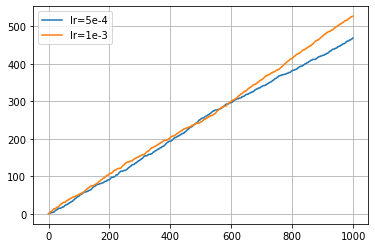

In [69]:
plt.plot(m1_wins, label='lr=5e-4')
plt.plot(m2_wins, label='lr=1e-4')
plt.legend()
plt.grid()
plt.savefig('results2.png')
plt.show()

In [9]:
!python 4anim.py

[INFO   ] [Logger      ] Record log in C:\Users\otnie\.kivy\logs\kivy_21-08-19_1.txt
[INFO   ] [deps        ] Successfully imported "kivy_deps.angle" 0.3.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.glew" 0.3.0
[INFO   ] [deps        ] Successfully imported "kivy_deps.sdl2" 0.3.1
[INFO   ] [Kivy        ] v2.0.0
[INFO   ] [Kivy        ] Installed at "D:\Programming\anaconda3\lib\site-packages\kivy\__init__.py"
[INFO   ] [Python      ] v3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
[INFO   ] [Python      ] Interpreter at "D:\Programming\anaconda3\python.exe"
[INFO   ] [Factory     ] 186 symbols loaded
[INFO   ] [Image       ] Providers: img_tex, img_dds, img_sdl2, img_pil (img_ffpyplayer ignored)
[INFO   ] [Text        ] Provider: sdl2
[INFO   ] [Window      ] Provider: sdl2
[INFO   ] [GL          ] Using the "OpenGL" graphics system
[INFO   ] [GL          ] GLEW initialization succeeded
[INFO   ] [GL          ] Backend used <glew>
[INFO   ] [GL       